In [1]:
!pip install -q open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 48.6 kB/s eta 0:00:00


## Dataset

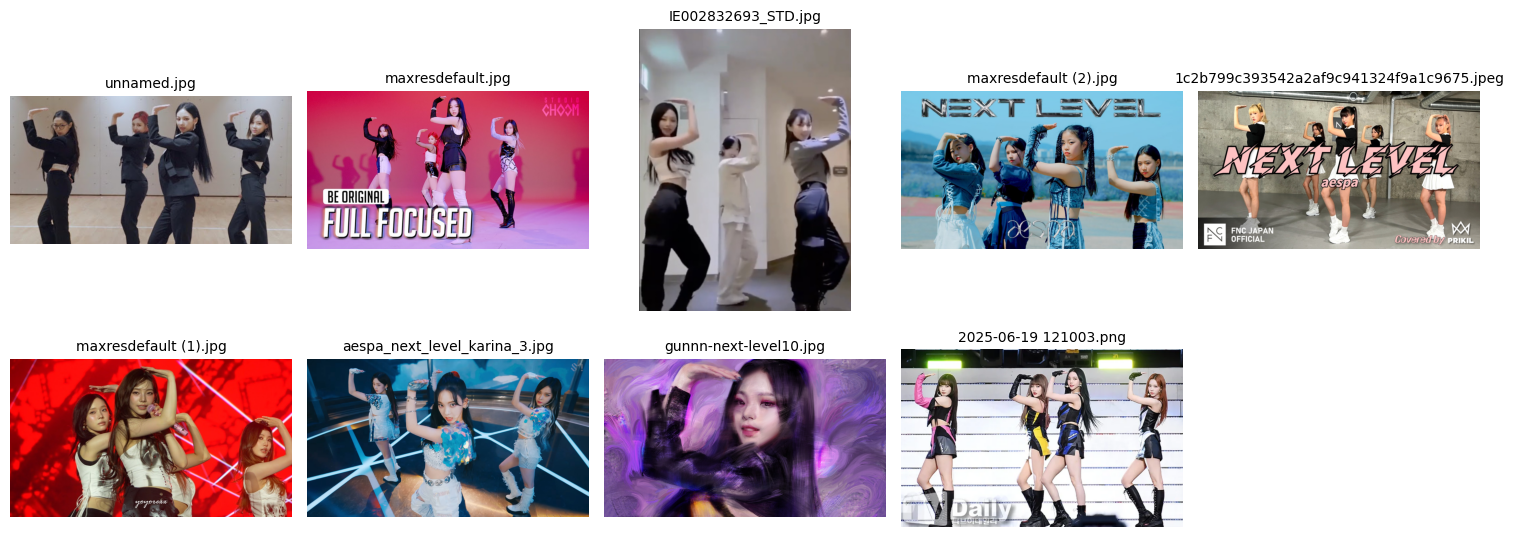

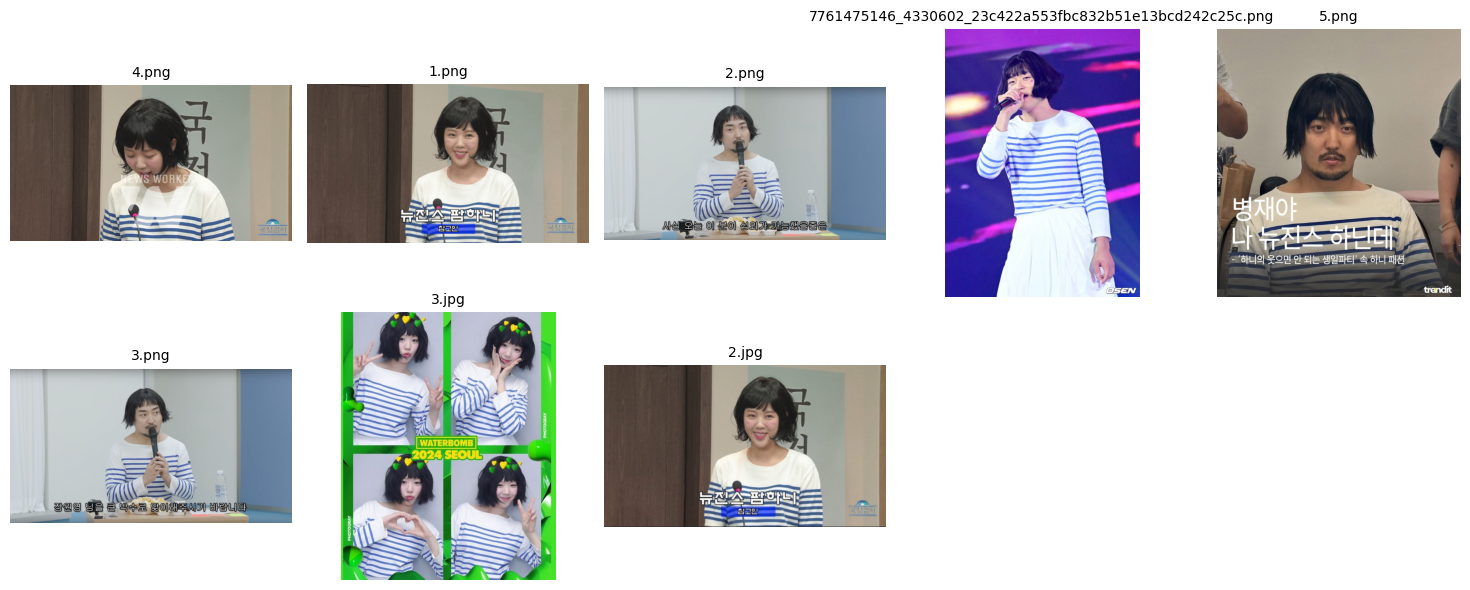

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# ✅ 학습 데이터 설정
# image_dir = "/kaggle/input/next-level-choreo"

pos_dir = "/kaggle/input/next-level-choreo"
neg_dirs = [
    # "/kaggle/input/train-img/pham_hani",
    "/kaggle/input/train-img/not_pham_hani"
]

# ✅ 데이터 로딩
def collect_images_from(folder):
    return [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]

positive_paths = collect_images_from(pos_dir)
negative_paths = []


for d in neg_dirs:
    negative_paths += collect_images_from(d)


# ✅ 최대 10장까지만 시각화
for image_paths in [positive_paths, negative_paths]:
    num_to_show = min(10, len(image_paths))
    cols = 5
    rows = (num_to_show + cols - 1) // cols
    
    plt.figure(figsize=(15, 3 * rows))
    for i in range(num_to_show):
        img = Image.open(image_paths[i])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(image_paths[i]), fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## Fine-tuning

In [3]:
!pip install -q open_clip_torch

import os
import open_clip
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 모델 준비
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.to(device)


# ✅ 학습 파라미터
num_epochs = 5
batch_size = 8
text_prompt = "next level"

# ✅ 학습 루프
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
model.train()

for epoch in range(num_epochs):
    # Shuffle negatives per epoch
    random.shuffle(negative_paths)
    total_loss = 0.0

    for pos_path, neg_path in zip(positive_paths, negative_paths[:len(positive_paths)]):
        try:
            pos_img = preprocess(Image.open(pos_path).convert("RGB")).unsqueeze(0).to(device)
            neg_img = preprocess(Image.open(neg_path).convert("RGB")).unsqueeze(0).to(device)
        except Exception as e:
            print(f"❌ 오류 이미지 스킵: {e}")
            continue

        # 텍스트는 동일
        text_input = tokenizer([text_prompt]).to(device)

        # 이미지 임베딩
        pos_feat = F.normalize(model.encode_image(pos_img), dim=-1)
        neg_feat = F.normalize(model.encode_image(neg_img), dim=-1)
        text_feat = F.normalize(model.encode_text(text_input), dim=-1)

        # 유사도 계산
        pos_logits = pos_feat @ text_feat.T   # [1, 1]
        neg_logits = neg_feat @ text_feat.T   # [1, 1]

        # label 0 = 정답, label 1 = 오답 → logits 쌓기
        logits = torch.cat([pos_logits, neg_logits], dim=0)  # [2, 1]
        labels = torch.tensor([0, 1], dtype=torch.long, device=device)

        # 2개 중에서 첫 번째만 맞아야 함 → CrossEntropyLoss 적용
        probs = torch.cat([pos_logits, neg_logits], dim=1)  # [1, 2]
        loss = F.cross_entropy(probs, torch.tensor([0], device=device))  # only first is correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"✅ Epoch {epoch+1} - Avg Loss: {total_loss / len(positive_paths):.4f}")


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

✅ Epoch 1 - Avg Loss: 0.4920
✅ Epoch 2 - Avg Loss: 0.2594
✅ Epoch 3 - Avg Loss: 0.1749
✅ Epoch 4 - Avg Loss: 0.1434
✅ Epoch 5 - Avg Loss: 0.1290


## Inference

In [4]:
model.eval()
text_input = tokenizer(["next level"]).to(device)

def compute_similarity(image_paths, label):
    for img_path in image_paths:
        try:
            img = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        except Exception as e:
            print(f"❌ 오류 이미지: {img_path}, 사유: {e}")
            continue

        with torch.no_grad():
            img_feat = F.normalize(model.encode_image(img), dim=-1)
            txt_feat = F.normalize(model.encode_text(text_input), dim=-1)
            sim = (img_feat @ txt_feat.T).item()

        print(f"[{label}] {os.path.basename(img_path)} → similarity: {sim:.3f}")

# ✅ Positive 이미지 (next-level-choreo)
print("✅ Positive 샘플 유사도:")
compute_similarity(positive_paths, label="POS")

# ✅ Negative 이미지 (pham_hani, not_pham_hani)
print("\n🚫 Negative 샘플 유사도:")
compute_similarity(negative_paths[:10], label="NEG")  # 10장만 보기


✅ Positive 샘플 유사도:
[POS] unnamed.jpg → similarity: 0.943
[POS] maxresdefault.jpg → similarity: 0.941
[POS] IE002832693_STD.jpg → similarity: 0.936
[POS] maxresdefault (2).jpg → similarity: 0.950
[POS] 1c2b799c393542a2af9c941324f9a1c9675.jpeg → similarity: 0.935
[POS] maxresdefault (1).jpg → similarity: 0.945
[POS] aespa_next_level_karina_3.jpg → similarity: 0.938
[POS] gunnn-next-level10.jpg → similarity: 0.934
[POS] 2025-06-19 121003.png → similarity: 0.859

🚫 Negative 샘플 유사도:
[NEG] 4.png → similarity: -0.954
[NEG] 2.png → similarity: -0.954
[NEG] 3.jpg → similarity: -0.941
[NEG] 2.jpg → similarity: -0.959
[NEG] 7761475146_4330602_23c422a553fbc832b51e13bcd242c25c.png → similarity: -0.941
[NEG] 1.png → similarity: -0.959
[NEG] 3.png → similarity: -0.954
[NEG] 5.png → similarity: -0.948


In [5]:
test_lyrics = [
    "next level",         # 🔺 정답
    "bring it back",
    "kick it up",
    "hold on",
    "i'm on the top",
    "black mamba",
    "forever",
    "i got the power",
    "not your girl",
    "step back"
]

def compare_to_all_lyrics(image_paths, label, max_images=5):
    for img_path in image_paths[:max_images]:
        try:
            img = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        except Exception as e:
            print(f"❌ 이미지 오류: {img_path}, 사유: {e}")
            continue

        with torch.no_grad():
            img_feat = F.normalize(model.encode_image(img), dim=-1)
            text_token = tokenizer(test_lyrics).to(device)
            text_feat = F.normalize(model.encode_text(text_token), dim=-1)
            sim = (img_feat @ text_feat.T)[0]  # shape: [10]

        print(f"\n🔍 [{label}] {os.path.basename(img_path)}:")
        for t, s in zip(test_lyrics, sim.tolist()):
            print(f"   - {t:20s} : {s:.3f}")

# ✅ Positive 샘플 테스트
print("✅ Positive 샘플 유사도:")
compare_to_all_lyrics(positive_paths, label="POS")

# ✅ Negative 샘플 테스트
print("\n🚫 Negative 샘플 유사도:")
compare_to_all_lyrics(negative_paths, label="NEG")


✅ Positive 샘플 유사도:

🔍 [POS] unnamed.jpg:
   - next level           : 0.943
   - bring it back        : 0.602
   - kick it up           : 0.561
   - hold on              : 0.482
   - i'm on the top       : 0.472
   - black mamba          : 0.643
   - forever              : 0.514
   - i got the power      : 0.553
   - not your girl        : 0.559
   - step back            : 0.497

🔍 [POS] maxresdefault.jpg:
   - next level           : 0.941
   - bring it back        : 0.596
   - kick it up           : 0.546
   - hold on              : 0.485
   - i'm on the top       : 0.478
   - black mamba          : 0.623
   - forever              : 0.513
   - i got the power      : 0.551
   - not your girl        : 0.573
   - step back            : 0.492

🔍 [POS] IE002832693_STD.jpg:
   - next level           : 0.936
   - bring it back        : 0.590
   - kick it up           : 0.564
   - hold on              : 0.493
   - i'm on the top       : 0.474
   - black mamba          : 0.651
   - forever     